# A Data Science Classification Case Study Project

A comprehensive roadmap towards approaching a data science classifiation project, covering all major steps - from exploratory data analysis and data preprocessing to hyperparameter tuning - to create the most effective predictive model. More specifically, the following steps are demonstrated:
* Exploratory Data Analysis (EDA)
* dataset splitting early on to avoid data leakage
* missing values imputation
* encoding (categorical -> numerical data)
* feature scaling, encoding, unskewing
* feature extraction
* automated hyperparameter tuning using GridSearchCV with pipelines and parameter grids

We'll use the Titanic classification dataset since it has various preprocessing needs.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from scipy.stats import boxcox, yeojohnson
from scipy.special import inv_boxcox
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, make_scorer, f1_score

In [2]:
# Load dataset
url = "titanic.csv"
df = pd.read_csv(url)

## Exploratory Data Analysis

In [3]:
# print 5 first observations to start getting familiar with the dataset
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Variable   | Definition    | Key

survival     Survival        0 = No, 1 = Yes

pclass       Ticket class    1 = 1st, 2 = 2nd, 3 = 3rd

sex          Gender

Age          Age in years

sibsp        # of siblings / spouses aboard the Titanic

parch        # of parents / children aboard the Titanic

ticket       Ticket number

fare         Passenger fare

cabin        Cabin number 

embarked     Port of Embarkation   C = Cherbourg, Q = Queenstown, S = Southampton

In [4]:
# print column types
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
# Missing values
missing_values = df.isnull().sum()
print("Missing Values per Column:")
missing_values

Missing Values per Column:


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
# Summary statistics for numerical features
print("Summary Statistics:")
df.describe()

Summary Statistics:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
# drop unnecessary columns such as PassengerId, Name, Ticket and cabin which is a column with high number of missing values
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

#### Check if dataset is balanced / unbalanced

Knowing the class distribution helps understand the overall dataset's structure and potential biases in the data.

Some key considerations:
* If one class is significantly underrepresented, machine learning models may become biased toward the majority class. This can lead to poor generalization and inaccurate predictions, particularly for the minority class.
* In unbalanced datasets, traditional metrics like accuracy can be misleading. For example, a model that always predicts the majority class can achieve high accuracy but fail to predict the minority class effectively. Therefore F1-score (with weighted average), precision and recall metrics will be more appropriate.
* If the dataset is unbalanced, we might consider oversampling the minority class, undersampling the majority class, or using techniques like SMOTE (Synthetic Minority Over-sampling Technique) to balance the dataset before training.

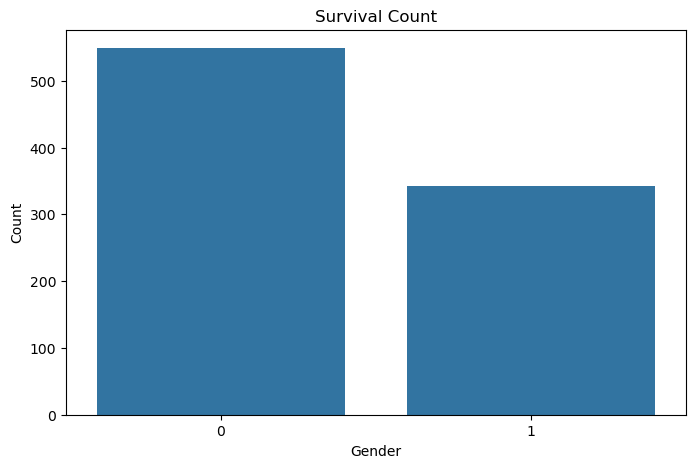

In [8]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Survived')
plt.title('Survival Count')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In [9]:
# Calculate the percentage of each class in the target variable
class_percentages = df['Survived'].value_counts(normalize=True) * 100

print("Percentage of each class in the target variable:\n", class_percentages)

Percentage of each class in the target variable:
 Survived
0    61.616162
1    38.383838
Name: proportion, dtype: float64


A target variable with class distribution of 62% for one class and 38% for the other is moderately imbalanced.

While this level of imbalance is not as extreme as, say, 90%-10%, it can still impact the performance of certain classifiers, especially if the minority class is the one you are most interested in predicting accurately. Generally, a dataset is considered "balanced" if the classes are close to a 50-50 distribution. However, many algorithms like ensemble algorithms can handle moderate imbalances, like this one, without significant issues.

#### Countplot for survival by gender

Reasoning: This count plot helps visualize the relationship between gender and survival rates. Since the Titanic disaster was notorious for differences in survival based on gender, this graph can reveal whether there was a significant disparity in survival rates between males and females.

What to Look For: We want to see if females had a higher survival rate compared to males, which is expected based on historical accounts. A clear difference in counts will highlight the impact of gender on survival (feature importance).

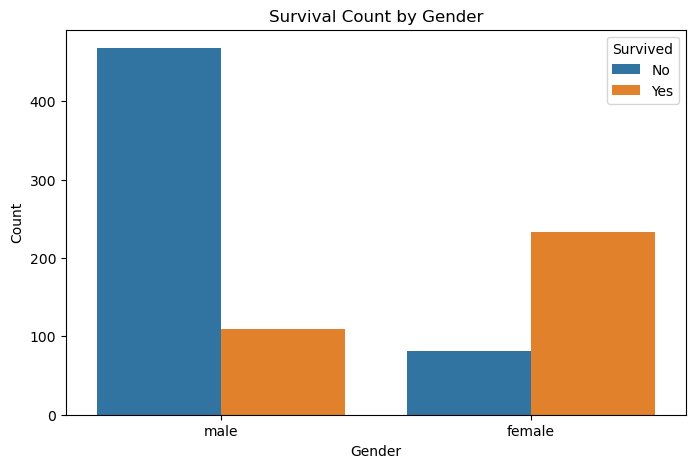

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(data=df, x='Sex', hue='Survived')
ax.set_title('Survival Count by Gender')
ax.set_xlabel('Gender')
ax.set_ylabel('Count')
ax.legend(title='Survived', loc='upper right', labels=['No', 'Yes'])

#### Countplot for survival by embarked

Reasoning: This count plot helps visualize the relationship between embarked and survival rates.

What to Look For: We want to see if the embarkation port plays important role on survival.

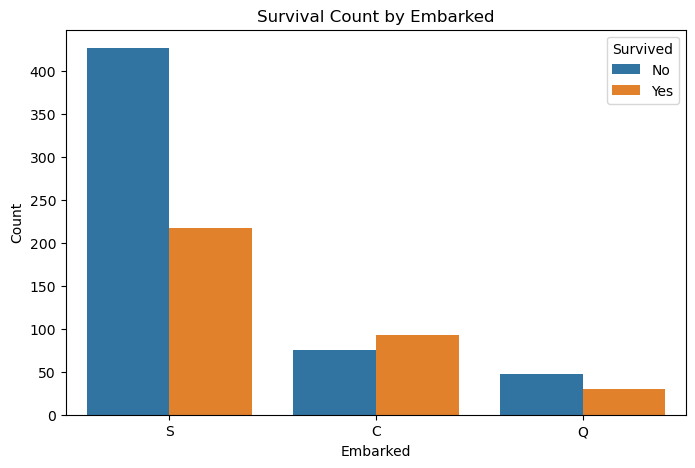

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(data=df, x='Embarked', hue='Survived')
ax.set_title('Survival Count by Embarked')
ax.set_xlabel('Embarked')
ax.set_ylabel('Count')
ax.legend(title='Survived', loc='upper right', labels=['No', 'Yes'])

#### Countplot for survival by Pclass

Reasoning: The Pclass variable categorizes passengers into three classes based on the ticket they purchased. Analyzing survival rates by passenger class can provide insights into how socioeconomic status affected survival chances during the Titanic disaster.

What to Look For: We want to observe the survival counts across the three classes. Generally, it is expected that 1st-class passengers would have a significantly higher survival rate compared to those in 2nd and 3rd class. This can provide a stark visual representation of the impact of class on survival rates.

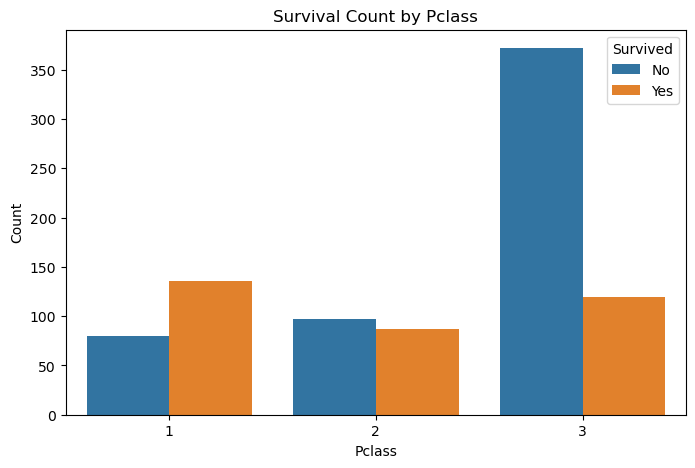

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(data=df, x='Pclass', hue='Survived')
ax.set_title('Survival Count by Pclass')
ax.set_xlabel('Pclass')
ax.set_ylabel('Count')
ax.legend(title='Survived', loc='upper right', labels=['No', 'Yes'])

#### Age Distribution of Passengers

Reasoning: The age distribution histogram allows us to understand the demographics of the passengers aboard the Titanic. Knowing the age distribution can help us assess how age factors into survival, particularly whether younger or older passengers had different survival rates.

What to Look For: We look for the shape of the distribution (normal, skewed, bimodal, etc.) and any age groups that are overrepresented or underrepresented. This can indicate trends in who was traveling on the Titanic.

Text(0, 0.5, 'Frequency')

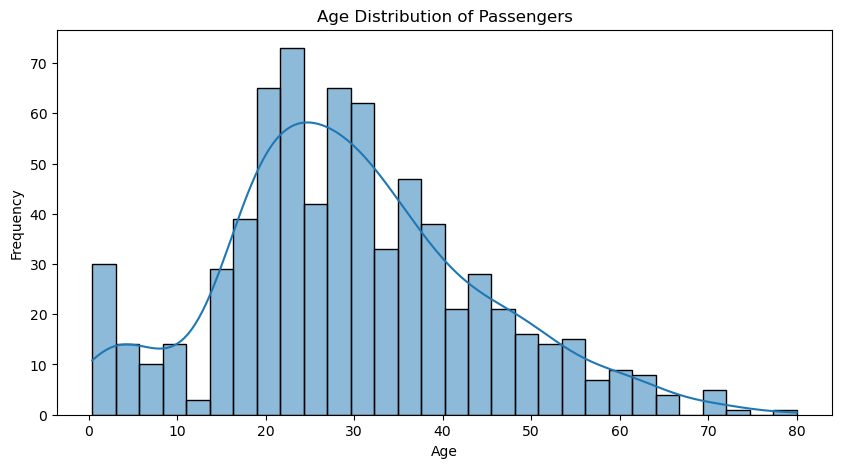

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=df, x='Age', bins=30, kde=True)
ax.set_title('Age Distribution of Passengers')
ax.set_xlabel('Age')
ax.set_ylabel('Frequency')

#### Fare Distribution of Passengers

Reasoning: This graphs allows us to understand the underlying fare distribution as a function of the survival status.

What to Look For: We look for the shape of the distribution (normal, skewed, bimodal, etc.).

Text(0, 0.5, 'Frequency')

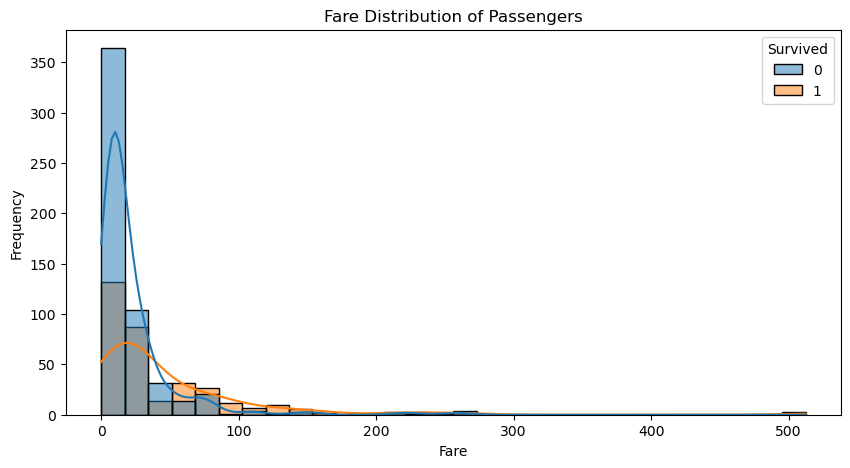

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=df, x='Fare', hue='Survived', bins=30, kde=True)
ax.set_title('Fare Distribution of Passengers')
ax.set_xlabel('Fare')
ax.set_ylabel('Frequency')

#### Split dataset

In [15]:
# Split features and target
X = df.drop('Survived', axis=1)
y = df['Survived']

In [16]:
# Split the data into training and test sets before scaling, encoding to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data Preprocessing and hyperparameter tuning

In a data science project, particularly after completing exploratory data analysis (EDA) and data splitting, there are basically 2 approaches to follow:

#### Approach A: Create Different Dataset Versions (based on different pre-processing strategies) and Evaluate Multiple Estimators

Process: 
* Perform imputation, scaling, encoding and transformations on the original dataset to create multiple versions of the dataset. 
* Apply various estimators (regressors or classifiers depending on the target variable) with default hyperparameters on each version of the dataset. 
* Use cross-validation to evaluate performance and identify the best-performing models.

Advantages:
* Model Diversity: This approach allows you to explore how different preprocessing strategies (scaling and encoding) impact model performance across various estimators.
* Insightful Results: By evaluating multiple estimators on different dataset versions, you gain insights into which preprocessing methods work best with specific models.
* Initial Benchmarking: It helps identify a few strong candidates for further hyperparameter tuning without getting bogged down in complex grid searches early on.

Disadvantages:
* Time-Consuming: This approach can be computationally expensive and time-consuming, especially with a large number of dataset versions and models.
* Overhead: Managing and comparing multiple datasets can become cumbersome.

#### Approach B: Use Pipelines (to apply different pre-processing strategies) and GridSearchCV for Hyperparameter Tuning

Process:
* Define a pipeline that incorporates preprocessing steps (imputation, scaling, encoding, transformations) and estimators.
* Perform GridSearchCV to tune hyperparameters (use a grid of different combination of hyperparameters) while evaluating different preprocessing techniques in the pipeline.

Advantages:
* Efficiency: This approach is more streamlined and efficient, allowing you to optimize hyperparameters and preprocessing steps in a single step.
* Integrated Approach: By using pipelines, you ensure that the same preprocessing steps are applied consistently during both training and evaluation, reducing the risk of data leakage.

Disadvantages:
* Limited Exploration: You may miss out on valuable insights that come from exploring a wider range of models and preprocessing strategies manually (intermediate results are not apparent).
* Complexity: Setting up pipelines and managing the hyperparameter search space can become complex, particularly if there are many preprocessing options to consider.

#### Recommended Approach

In practice, a hybrid approach often works best:

* Start with Approach A: Conduct initial experiments with different preprocessing strategies and a larger variety of models using default hyperparameters to understand which combinations yield the best performance.
* Narrow Down: Based on the initial findings, narrow down to the top 2-3 models and their best-performing preprocessing methods.
* Then Move to Approach B: Utilize GridSearchCV with pipelines for these selected models and preprocessors to fine-tune hyperparameters.

This combined strategy allows you to benefit from both broad exploration and focused optimization, leading to more robust model development and potentially better performance.

#### APPROACH A

##### *Dataset V1*
1. Apply simple imputer with mean strategy on numerical features
2. Apply robust scaler on age and fare
3. Apply simple imputer with most frequent strategy and ordinal encoding on categorical features

In [17]:
X_train_V_1 = X_train.copy()
X_test_V_1 = X_test.copy()

# Identify numerical and categorical features
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

# Apply simple imputer with mean strategy on numerical features
si1 = SimpleImputer(strategy='mean')
# fit (train) imputer on the training dataset
si1.fit(X_train_V_1[num_features])
# apply imputation on both training and test datasets
X_train_V_1[num_features] = si1.transform(X_train_V_1[num_features])
X_test_V_1[num_features] = si1.transform(X_test_V_1[num_features])

# ALTERNATIVELY: you could fit and transform training data at the same time and then transform test data separately
#X_train_V_1[num_features] = si1.fit_transform(X_train_V_1[num_features])
#X_test_V_1[num_features] = si1.transform(X_test_V_1[num_features])

# Apply robust scaling on Age and Fare
rs = RobustScaler()
features_to_scale = ['Age', 'Fare']
rs.fit(X_train_V_1[features_to_scale])
X_train_V_1[features_to_scale] = rs.transform(X_train_V_1[features_to_scale])
X_test_V_1[features_to_scale] = rs.transform(X_test_V_1[features_to_scale])

# Apply simple imputer with most_frequent strategy on categorical features
si2 = SimpleImputer(strategy='most_frequent')
si2.fit(X_train_V_1[cat_features])
X_train_V_1[cat_features] = si2.transform(X_train_V_1[cat_features])
X_test_V_1[cat_features] = si2.transform(X_test_V_1[cat_features])

# Apply ordinal encoding on categorical features
ordinal_encoder = OrdinalEncoder(return_df=True,
                                 handle_unknown='value',   # Handle unknown categories in the test set (at transform time) --> Encode unseen categories with -1
                                )
X_train_V_1[cat_features] = ordinal_encoder.fit_transform(X_train_V_1[cat_features])
X_test_V_1[cat_features] = ordinal_encoder.transform(X_test_V_1[cat_features])

#print(X_train_V_1)
#print(X_test_V_1)

##### *Dataset V2*

1. Apply simple imputer with mean strategy on numerical features
2. Apply yeo johnson (unskewing) on age and fare
3. Apply simple imputer with most frequent strategy and ordinal encoding on categorical features

In [18]:
X_train_V_2 = X_train.copy()
X_test_V_2 = X_test.copy()

# Apply simple imputer with mean strategy on numerical features
si1 = SimpleImputer(strategy='mean')
# train imputer on the training dataset
si1.fit(X_train_V_2[num_features])
# apply imputation on both training and test datasets
X_train_V_2[num_features] = si1.transform(X_train_V_2[num_features])
X_test_V_2[num_features] = si1.transform(X_test_V_2[num_features])

# Initialize the PowerTransformer with Yeo-Johnson method
# We could apply Box-Cox if all data were positive; Fare column contains zero values
transformer = PowerTransformer(method='yeo-johnson')

X_train_V_2[features_to_scale] = transformer.fit_transform(X_train_V_2[features_to_scale])  # Fit and transform training data (Age and Fare columns only)
X_test_V_2[features_to_scale] = transformer.transform(X_test_V_2[features_to_scale])  # Transform test data

# Copy the transformations on categorical data from the first dataset as they are the same
X_train_V_2[cat_features] = X_train_V_1[cat_features].copy()
X_test_V_2[cat_features] = X_test_V_1[cat_features].copy()
    
#print(X_train_V_2)
#print(X_test_V_2)

##### *Dataset V3* (the same as V2 but one hot on categorical)
1. Apply simple imputer with mean strategy on numerical features
2. Apply yeo johnson (unskewing) on age and fare
3. Apply simple imputer with most frequent strategy and one hot encoding on categorical features

In [19]:
X_train_V_3 = X_train_V_2.copy()
X_test_V_3 = X_test_V_2.copy()

# Apply one hot encoding on categorical features
onehot_encoder = OneHotEncoder(return_df=True,
                                 handle_unknown='value',   # Handle unknown categories in the test set (at transform time) --> Encode a new value as 0 in every dummy column
                                )
new_cols_train = onehot_encoder.fit_transform(X_train[cat_features])
# Concatenate the original DataFrame with the encoded DataFrame
X_train_V_3 = pd.concat([X_train_V_3, new_cols_train], axis=1)
# Drop the original categorical column if you no longer need it
X_train_V_3 = X_train_V_3.drop(columns=cat_features)

new_cols_test = onehot_encoder.transform(X_test[cat_features])
X_test_V_3 = pd.concat([X_test_V_3, new_cols_test], axis=1)
X_test_V_3 = X_test_V_3.drop(columns=cat_features)

#print(X_train_V_3)
#print(X_test_V_3)

##### *Dataset V4* (the same as V3 but with PCA)
1. Apply simple imputer with mean strategy on numerical features
2. Apply yeo johnson (unskewing) on age and fare
3. Apply simple imputer with most frequent strategy and one hot encoding on categorical features
4. PCA for feature extraction (dimensionality reduction) - even though PCA is not appropriate for datasets involving discrete numerical features, here is used for educational purposes. 

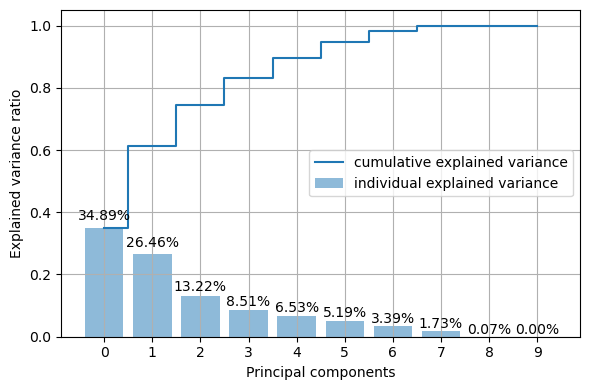

In [20]:
X_train_V_4 = X_train_V_3.copy()
X_test_V_4 = X_test_V_3.copy()

# function that plots the variance explained by each new feature
def print_variance_explained_plot(obj, n_components):
    cum_var_exp = np.cumsum(obj.explained_variance_ratio_)
    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar(range(n_components), obj.explained_variance_ratio_, alpha=0.5, align='center',
                label='individual explained variance')
    # show percentage of explained variance on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., 1.05*height, '%.2f%%' % (height*100), 
                ha='center', va='bottom')
    plt.step(range(n_components), cum_var_exp, where='mid',
                 label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.xticks( range(n_components) )
    plt.grid(True)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

pca = PCA(n_components=10)
pca.fit(X_train_V_4)
print_variance_explained_plot(pca, 10)

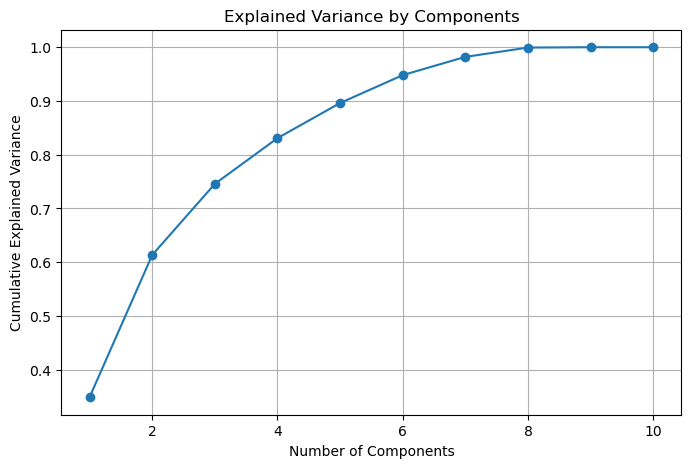

In [21]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid()
plt.show()

In [22]:
#  Choose an adequate number of components to achieve cumulative variance ~ 90-95%
# 80%-90%: Often sufficient in many real-world cases, balancing dimensionality reduction and retaining meaningful information.
# >95%: For datasets where preserving most information is critical, such as scientific or engineering applications.
# <80%: In cases where some loss of information is acceptable, such as when working with very large datasets and prioritizing computational efficiency.

pca = PCA(n_components=6)
X_train_V_4 = pca.fit_transform(X_train_V_4)
X_test_V_4 = pca.transform(X_test_V_4)

#print(X_train_V_4)
#print(X_test_V_4)

#### Model Selection

Train 9 classifiers using training datasets: RandomForestClassifier, AdaBoostClassifier, XGBoostClassifier, CatBoostClassifier, SVC, KNeighborsClassifier, LogisticRegressor, DecisionTreeClassfier and GaussianNB using 10-fold CV.

Make predictions using test datasets and choose the top 2 best performing models.

In [23]:
featuresets = {
    'v1': X_train_V_1,
    'v2': X_train_V_2, 
    'v3': X_train_V_3,
    'v4': X_train_V_4    
}

# Define classifiers
classifiers = {
    "RandomForest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(algorithm='SAMME'),
    "XGBoost": XGBClassifier(),
    "CatBoost": CatBoostClassifier(silent=True),
    "SVC": SVC(),
    "KNeighbors": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(),
    "DecisionTree": DecisionTreeClassifier(),
    "GaussianNB": GaussianNB()
}

# Dictionary to store results
results = []

f1_score_weighted = make_scorer(f1_score, average='weighted')

# Loop over each featureset version
for featureset, X_data in featuresets.items():
    # Loop over each classifier
    print(featureset+":", end=' ... ')
    for clf_name, clf in classifiers.items():
        print(clf_name, end=' ... ')
        # Perform 10-fold cross-validation
        scores = cross_val_score(clf, X_data, y_train, cv=10, scoring=f1_score_weighted, n_jobs=-1)
        # Store the average score for this classifier and dataset version
        avg_score = scores.mean()
        results.append({
            'featureset': featureset,
            'classifier': clf_name,
            'score': avg_score
        })
    print()

v1: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVC ... KNeighbors ... LogisticRegression ... DecisionTree ... GaussianNB ... 
v2: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVC ... KNeighbors ... LogisticRegression ... DecisionTree ... GaussianNB ... 
v3: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVC ... KNeighbors ... LogisticRegression ... DecisionTree ... GaussianNB ... 
v4: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVC ... KNeighbors ... LogisticRegression ... DecisionTree ... GaussianNB ... 


In [24]:
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)
results_df

,featureset,classifier,score
0,v1,RandomForest,0.786370
1,v1,AdaBoost,0.816304
2,v1,XGBoost,0.790727
3,v1,CatBoost,0.818617
4,v1,SVC,0.813544
5,v1,KNeighbors,0.772192
6,v1,LogisticRegression,0.793273
7,v1,DecisionTree,0.742608
8,v1,GaussianNB,0.791100
9,v2,RandomForest,0.793826


In [25]:
# Best performing classifiers: SVC, AdaBoostClssifier
results_df.groupby(['classifier'])['score'].agg(['mean']).sort_values(by='mean', ascending=False)

,mean
classifier,
SVC,0.822760
CatBoost,0.812544
AdaBoost,0.806950
LogisticRegression,0.793435
XGBoost,0.785388
RandomForest,0.784509
KNeighbors,0.782343
DecisionTree,0.737184
GaussianNB,0.729796


In [26]:
# Best performing featureset versions: v1, v2
results_df.groupby(['featureset'])['score'].agg(['mean']).sort_values(by='mean', ascending=False)

,mean
featureset,
v2,0.792688
v1,0.791637
v4,0.778227
v3,0.772962


#### APPROACH B

Use pipelines and GridSearchCV to fine tune the hyperparameters of the top 2 best performing models. Pipelines should involve the best performing featureset versions.

In [27]:
# Preprocessing pipeline for numerical features that need only imputing (not scaling, nor unskewing)
num_pipeline1 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
])
# Preprocessing pipeline for numerical features that need imputing + scaling
num_pipeline2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])
# Preprocessing pipeline for numerical features that need imputing + unskewing
num_pipeline3 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('unskewer', PowerTransformer(method='yeo-johnson'))
])
# Preprocessing pipeline for cateorical features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='value'))
])

# preprocessing pipeline for creating featureset v1
preprocessor1 = ColumnTransformer(
    transformers=[
        ('num1', num_pipeline1, list(set(num_features) - set(features_to_scale))),  # all numerical features minus features to be scaled
        ('num2', num_pipeline2, features_to_scale),                                 # numerical features to be scaled 
        ('cat', cat_pipeline, cat_features)
    ],
    remainder='passthrough'
)
# preprocessing pipeline for creating featureset v2
preprocessor2 = ColumnTransformer(
    transformers=[
        ('num1', num_pipeline1, list(set(num_features) - set(features_to_scale))),  # all numerical features minus features to be unskewed
        ('num2', num_pipeline3, features_to_scale),                                 # numerical features to be unskewed
        ('cat', cat_pipeline, cat_features)
    ],
    remainder='passthrough'
)
# IMPORTANT NOTICE: avoid using multiple consecutive column transformers since they alter column order

#X_transformed = preprocessor1.fit_transform(X_train)
#f = pd.DataFrame(X_transformed, columns = X_train.columns)
#print(f.head(3))

# Create 4 pipelines with different preprocessing steps
pipeline1 = Pipeline([
    ('preprocessor', preprocessor1),
    ('classifier', SVC())
])
pipeline2 = Pipeline([
    ('preprocessor', preprocessor1),
    ('classifier', AdaBoostClassifier())
])
pipeline3 = Pipeline([
    ('preprocessor', preprocessor2),
    ('classifier', SVC())
])
pipeline4 = Pipeline([
    ('preprocessor', preprocessor2),
    ('classifier', AdaBoostClassifier())
])

# Define different pipelines with different classifiers and preprocessing steps
pipelines = {
    'svc_v1_pipeline': pipeline1,
    'ada_v1_pipeline': pipeline2,
    'svc_v2_pipeline': pipeline3,
    'ada_v2_pipeline': pipeline4
}

# Set up parameter grid for GridSearchCV to explore both pipelines
param_grid1 = [
    {'classifier__C': [0.01, 0.1, 1, 10, 100], 'classifier__kernel': ['linear', 'rbf', 'poly'], 'classifier__gamma': ['scale', 'auto']}
]
param_grid2 = [
    {'classifier__n_estimators': [50, 100, 200, 500], 'classifier__learning_rate': [0.01, 0.1, 1.0, 10], 'classifier__algorithm': ['SAMME'] }
]

param_grids = {
    'svc_v1_pipeline': param_grid1,
    'ada_v1_pipeline': param_grid2,
    'svc_v2_pipeline': param_grid1,
    'ada_v2_pipeline': param_grid2
}

# Loop through each pipeline and perform GridSearchCV
best_estimators = {}
for pipeline_name, pipeline in pipelines.items():
    print(f"Running GridSearchCV for {pipeline_name}...")
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grids[pipeline_name], cv=5, scoring=f1_score_weighted, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Store the best estimator and results for each pipeline
    best_estimators[pipeline_name] = grid_search.best_estimator_
    print(f"Best Parameters for {pipeline_name}: {grid_search.best_params_}")
    print(f"Best Cross-Validated Score for {pipeline_name}: {grid_search.best_score_}")
    
    # Make predictions using the best estimator
    y_pred = grid_search.best_estimator_.predict(X_test)  # Use X_test for evaluation
    print(f"Performance on the test dataset: {f1_score(y_test, y_pred, average='weighted')}") # Evaluate on the test dataset
    print("")

Running GridSearchCV for svc_v1_pipeline...
Best Parameters for svc_v1_pipeline: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best Cross-Validated Score for svc_v1_pipeline: 0.8210361553389683
Performance on the test dataset: 0.8134622171398872

Running GridSearchCV for ada_v1_pipeline...
Best Parameters for ada_v1_pipeline: {'classifier__algorithm': 'SAMME', 'classifier__learning_rate': 1.0, 'classifier__n_estimators': 200}
Best Cross-Validated Score for ada_v1_pipeline: 0.8061583336386026
Performance on the test dataset: 0.8091929317716401

Running GridSearchCV for svc_v2_pipeline...
Best Parameters for svc_v2_pipeline: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best Cross-Validated Score for svc_v2_pipeline: 0.8202521000881422
Performance on the test dataset: 0.8140397158008151

Running GridSearchCV for ada_v2_pipeline...
Best Parameters for ada_v2_pipeline: {'classifier__algorithm': 'SAMME', 'classifier__learn

### Μeasure the performance of the best model

In [28]:
# Create the best model (using the best hyper-parameter values obtained frm the previous step)
best_model = SVC(C=10, gamma='scale', kernel='rbf')
# train the model on the dataset that achieves the highest score
best_model.fit(X_train_V_1, y_train)
# make prediction on the train dataset in order to check for overfitting 
# (overfitting arises when high performance on training dataset and low performance on test dataset => model does not generalize
y_train_pred = best_model.predict(X_train_V_1)
print("F1 score on training dataset:", f1_score(y_train, y_train_pred, average='weighted'))

# make prediction on the test dataset
y_test_pred = best_model.predict(X_test_V_1)
print("F1 score on training dataset:", f1_score(y_test, y_test_pred, average='weighted'))

F1 score on training dataset: 0.8466357729290455
F1 score on training dataset: 0.8134622171398872


Determining if a model is overfitting based on the difference in f1 scores between the training and test datasets involves some judgment. Here are general guidelines:

Key Considerations:

* Small Gap: A small difference between f1 scores on training and test datasets (e.g., within 5-10%) suggests the model generalizes well.
    * Example: Training f1: 0.85, Test f1: 0.80. This is acceptable.
* Large Gap: A large difference between training and test f1 scores indicates overfitting. If the training f1 is high, but the test f1 is significantly lower, your model is likely memorizing the training data instead of learning the underlying patterns.
    * Example: Training f1: 0.95, Test f1: 0.60. This is a sign of overfitting.
* Low f1 on both: If both the training and test f1 scores are low, it suggests underfitting. The model may be too simple, or the features provided are insufficient for the task.
* Class Imbalance Impact: f1 scores are particularly sensitive to class imbalance. Overfitting may result in high training f1 for the majority class but poor generalization to minority classes in the test set.

In our case, the difference in f1 scores between training and test datasets is relatively low and thus acceptable suggesting no overfitting.